# SMART-QSO Power/Energy Simulation (1 s resolution)

This notebook simulates the spacecraft power/energy balance at 1 s resolution across the ConOps phases (LEOP, Commissioning, Nominal Ops, EOL) using simplified orbit lighting and subsystem load models.

- Orbit lighting: configurable orbit period and sunlit duration per orbit (cylindrical shadow approximation)
- Solar generation: constant panel output in sunlit portions with scale factors for attitude/seasonal effects
- Battery model: simple coulomb counter with charge/discharge efficiency and SOC limits
- Subsystem loads: OBC base, Beacon (stochastic cadence), ADCS (detumble), Jetson payload (power-aware gating), heaters (optional)

Defaults use compressed durations for demonstration. Adjust config to match mission assumptions. Refer to `mission/CONOPS.md` for phase definitions.


In [17]:
# Config: orbit, panels, battery, subsystems
from dataclasses import dataclass

@dataclass
class OrbitConfig:
    period_s: int = 5400          # 90 min
    sunlit_s: int = 3000          # ~55% sunlit
    sim_dt_s: int = 1

@dataclass
class PanelConfig:
    sunlit_w: float = 10.0        # average sunlit array generation [W]
    eclipse_w: float = 0.1        # leakage/reflection [W]
    scale: float = 1.0            # seasonal/attitude scaling

@dataclass
class BatteryConfig:
    capacity_wh: float = 50.0     # usable Wh
    charge_eff: float = 0.95
    discharge_eff: float = 0.95
    soc_min: float = 0.05         # 5% reserve
    series_cells: int = 4         # 4S pack count
    r_internal_ohm: float = 0.25  # pack internal resistance [ohm]
    v_cell_min: float = 3.0
    v_cell_plateau_low: float = 3.6
    v_cell_plateau_high: float = 3.9
    v_cell_max: float = 4.2
    v_brownout_v: float = 13.2    # bus brownout threshold [V] (4S * 3.3V per cell)

@dataclass
class LoadsConfig:
    obc_w: float = 0.3
    beacon_idle_w: float = 0.1    # idle beacon electronics [W]
    beacon_tx_w: float = 0.5      # transmit power draw [W]
    adcs_detumble_w: float = 0.8
    adcs_idle_w: float = 0.1
    jetson_w: float = 8.0         # declocked burst avg when on
    heaters_w: float = 0.0

@dataclass
class BeaconConfig:
    interval_s: int = 120         # one transmission every N seconds
    tx_duration_s: int = 1        # seconds per transmission window

@dataclass
class ConOpsDurations:
    leop_s: int = 2*3600          # 2 h (compress for demo)
    commissioning_s: int = 6*3600 # 6 h
    nominal_s: int = 24*3600      # 1 day
    eol_s: int = 1*3600           # 1 h

orbit = OrbitConfig()
panels = PanelConfig()
batt = BatteryConfig()
loads = LoadsConfig()
beacon = BeaconConfig()
phases = ConOpsDurations()

# Mission gating thresholds
SOC_JETSON_EN = 0.60
SOC_SAFE_MODE = 0.25


In [18]:
# Helpers: orbit lighting, coulomb counter, stochastic beacon
import math
import random

random.seed(0)

def is_sunlit(t: int, orbit: OrbitConfig) -> bool:
    t_mod = t % orbit.period_s
    return t_mod < orbit.sunlit_s

class Battery:
    def __init__(self, cfg: BatteryConfig):
        self.cfg = cfg
        self.energy_wh = cfg.capacity_wh * 0.8  # start at 80% SOC
    @property
    def soc(self) -> float:
        return max(0.0, min(1.0, self.energy_wh / self.cfg.capacity_wh))
    def ocv_volts(self) -> float:
        # Simple piecewise-linear OCV per cell scaled by series_cells
        s = float(self.soc)
        c = self.cfg
        # Map soc -> per-cell OCV
        if s <= 0.0:
            v_cell = c.v_cell_min
        elif s < 0.1:
            # knee from min to plateau_low
            v_cell = c.v_cell_min + (c.v_cell_plateau_low - c.v_cell_min) * (s / 0.1)
        elif s < 0.9:
            # plateau
            v_cell = c.v_cell_plateau_low + (c.v_cell_plateau_high - c.v_cell_plateau_low) * ((s - 0.1) / 0.8)
        elif s < 1.0:
            # taper to max
            v_cell = c.v_cell_plateau_high + (c.v_cell_max - c.v_cell_plateau_high) * ((s - 0.9) / 0.1)
        else:
            v_cell = c.v_cell_max
        return float(v_cell * c.series_cells)
    def bus_voltage(self, load_w: float) -> float:
        # Positive load_w draws current; negative means net charge current
        v_oc = self.ocv_volts()
        if v_oc <= 0:
            return 0.0
        # Iterative solve is overkill; use one-step estimate with IR drop
        i_a = float(load_w) / max(1e-6, v_oc)
        v_bus = v_oc - i_a * self.cfg.r_internal_ohm
        # Clamp: cannot exceed max, cannot be negative
        if v_bus > self.cfg.series_cells * self.cfg.v_cell_max:
            v_bus = self.cfg.series_cells * self.cfg.v_cell_max
        if v_bus < 0.0:
            v_bus = 0.0
        return float(v_bus)
    def charge(self, p_w: float, dt_s: int):
        # p_w > 0 adds energy
        wh = (p_w * dt_s) / 3600.0
        self.energy_wh += wh * self.cfg.charge_eff
        if self.energy_wh > self.cfg.capacity_wh:
            self.energy_wh = self.cfg.capacity_wh
    def discharge(self, p_w: float, dt_s: int):
        # p_w > 0 draws energy
        wh = (p_w * dt_s) / 3600.0
        self.energy_wh -= wh / max(1e-6, self.cfg.discharge_eff)
        if self.energy_wh < 0.0:
            self.energy_wh = 0.0

def is_beacon_tx_second(t: int, cfg: BeaconConfig) -> bool:
    if cfg.interval_s <= 0 or cfg.tx_duration_s <= 0:
        return False
    return (t % max(1, cfg.interval_s)) < cfg.tx_duration_s


In [19]:
# Attitude and tumbling model (tip-off) and solar incidence
from dataclasses import dataclass
import numpy as np

@dataclass
class TipOffConfig:
    # Initial angular rates about body axes [deg/s]
    omega0_dps: tuple = (5.0, 5.0, 5.0)
    # Exponential decay time constant for detumble [s]
    tau_s: float = 1800.0

# Body-frame unit face normals: [+X, -X, +Y, -Y, +Z, -Z]
_FACE_NORMALS_B = np.array([
    [1.0, 0.0, 0.0],
    [-1.0, 0.0, 0.0],
    [0.0, 1.0, 0.0],
    [0.0, -1.0, 0.0],
    [0.0, 0.0, 1.0],
    [0.0, 0.0, -1.0],
], dtype=float)


def _quat_normalize(q: np.ndarray) -> np.ndarray:
    q = np.asarray(q, dtype=float)
    return q / max(1e-12, np.linalg.norm(q))


def _quat_multiply(q: np.ndarray, r: np.ndarray) -> np.ndarray:
    # Hamilton product (dq * q)
    w1, x1, y1, z1 = r
    w2, x2, y2, z2 = q
    return np.array([
        w1*w2 - x1*x2 - y1*y2 - z1*z2,
        w1*x2 + x1*w2 + y1*z2 - z1*y2,
        w1*y2 - x1*z2 + y1*w2 + z1*x2,
        w1*z2 + x1*y2 - y1*x2 + z1*w2,
    ], dtype=float)


def step_quaternion(q: np.ndarray, omega_b_rad_s: np.ndarray, dt_s: float) -> np.ndarray:
    # Integrate body rates over dt using small-angle exact axis-angle
    ang = float(np.linalg.norm(omega_b_rad_s) * dt_s)
    if ang < 1e-12:
        return q
    axis = omega_b_rad_s / (np.linalg.norm(omega_b_rad_s) + 1e-12)
    dq = np.array([np.cos(ang/2.0), *(np.sin(ang/2.0) * axis)], dtype=float)
    return _quat_normalize(_quat_multiply(dq, q))


def quat_to_R(q: np.ndarray) -> np.ndarray:
    # Rotation matrix from body to inertial
    q = _quat_normalize(q)
    w, x, y, z = q
    R = np.array([
        [1 - 2*(y*y + z*z), 2*(x*y - z*w),     2*(x*z + y*w)],
        [2*(x*y + z*w),     1 - 2*(x*x + z*z), 2*(y*z - x*w)],
        [2*(x*z - y*w),     2*(y*z + x*w),     1 - 2*(x*x + y*y)],
    ], dtype=float)
    return R


def solar_irradiance_fraction(q: np.ndarray, sun_dir_inertial: np.ndarray, faces_coverage: np.ndarray) -> float:
    # Project sun vector onto body faces with coverage weights
    R_bi = quat_to_R(q)
    s_b = R_bi.T @ (sun_dir_inertial / max(1e-12, np.linalg.norm(sun_dir_inertial)))
    denom = max(1e-6, float(np.sum(faces_coverage)))
    inc = 0.0
    for k, n_b in enumerate(_FACE_NORMALS_B):
        cosi = max(0.0, float(np.dot(n_b, s_b)))
        inc += float(faces_coverage[k]) * cosi
    return float(min(1.0, inc / denom))



In [20]:
# Panel coverage model and tip-off configuration
# Fractional PV coverage per face (sum can be <= 6 if partial coverage). Example: +Y/+Z carry deployables
faces_coverage = np.array([0.6, 0.6, 0.9, 0.9, 1.0, 1.0], dtype=float)
# Tip-off configuration (from NRCSD typical tip-off rates ~ 1-10 deg/s per axis; using a moderate 5 deg/s)
tipcfg = TipOffConfig(omega0_dps=(5.0, 4.0, 6.0), tau_s=1800.0)



In [21]:
# Helper to propagate tumbling attitude and compute solar power scale

def sun_dir_inertial_at_t(t: int, orbit: OrbitConfig) -> np.ndarray:
    # Simplified: sun vector in inertial flips with lighting determination; use +X during sunlit
    return np.array([1.0, 0.0, 0.0], dtype=float)


def omega_profile_dps(t: int, cfg: TipOffConfig) -> np.ndarray:
    # Exponential detumble (e.g., magnetorquer shedding)
    decay = np.exp(-float(t) / max(1e-6, cfg.tau_s))
    w0 = np.array(cfg.omega0_dps, dtype=float)
    return decay * w0


def solar_scale_from_tumbling(t: int, q_b2i: np.ndarray, cfg: TipOffConfig) -> tuple:
    # Integrate one step and compute panel incidence scale [0..1]
    w_dps = omega_profile_dps(t, cfg)
    w_rad = np.deg2rad(w_dps)
    q_next = step_quaternion(q_b2i, w_rad, orbit.sim_dt_s)
    s_i = sun_dir_inertial_at_t(t, orbit)
    frac = solar_irradiance_fraction(q_next, s_i, faces_coverage)
    return q_next, float(frac)



In [22]:
# Mission simulation
import numpy as np

bt = Battery(batt)

# Logs for voltage/current
v_bus_log = np.zeros(T_total, dtype=float)
i_bus_log = np.zeros(T_total, dtype=float)

# Initial attitude quaternion (body->inertial); start identity
q_b2i = np.array([1.0, 0.0, 0.0, 0.0], dtype=float)

# Phase schedule (compressed for demo)
phases_s = [
    ("LEOP", phases.leop_s),
    ("COMMISSIONING", phases.commissioning_s),
    ("NOMINAL", phases.nominal_s),
    ("EOL", phases.eol_s),
]

# Beacon cadence by phase (average seconds between emissions)
beacon_avg = {
    "LEOP": 120,
    "COMMISSIONING": 90,
    "NOMINAL": 60,
    "EOL": 180,
}

T_total = sum(d for _, d in phases_s)

soc_log = np.zeros(T_total, dtype=float)
load_w_log = np.zeros(T_total, dtype=float)
solar_w_log = np.zeros(T_total, dtype=float)
mode_log = []

for t in range(T_total):
    # Determine phase
    acc = 0
    for name, dur in phases_s:
        if t < acc + dur:
            phase = name
            break
        acc += dur

    sun = is_sunlit(t, orbit)

    # Compute solar incidence scaling under tumbling
    if sun:
        q_b2i, frac = solar_scale_from_tumbling(t, q_b2i, tipcfg)
        solar_w = (panels.sunlit_w * panels.scale) * frac
    else:
        # Eclipse; advance attitude by rates without generation
        q_b2i, _ = solar_scale_from_tumbling(t, q_b2i, tipcfg)
        solar_w = panels.eclipse_w

    # Base loads
    p_load = loads.obc_w + loads.adcs_idle_w + loads.heaters_w

    # Beacon power: idle baseline plus TX duty
    p_load += loads.beacon_idle_w
    if is_beacon_tx_second(t, beacon):
        p_load += max(0.0, loads.beacon_tx_w - loads.beacon_idle_w)

    # Detumble in LEOP initially (first 20 min)
    if phase == "LEOP" and t < 20*60:
        p_load += loads.adcs_detumble_w

    # Jetson gating by SOC and sunlit
    if (bt.soc >= SOC_JETSON_EN) and sun and (phase in ("COMMISSIONING", "NOMINAL")):
        p_load += loads.jetson_w

    # Estimate bus voltage with IR drop given instantaneous net draw (load minus solar)
    net_w = solar_w - p_load
    v_bus = bt.bus_voltage(load_w=max(0.0, p_load - solar_w))

    # Brownout protection: if bus below threshold, shed Jetson and ADCS detumble (keep only OBC + beacon idle + heaters)
    if v_bus < batt.v_brownout_v:
        # Recompute p_load with minimal set
        p_load = loads.obc_w + loads.beacon_idle_w + loads.heaters_w
        # If sunlit, add TX duty if it happens this second
        if is_beacon_tx_second(t, beacon):
            p_load += max(0.0, loads.beacon_tx_w - loads.beacon_idle_w)
        # Recompute bus voltage after shedding
        v_bus = bt.bus_voltage(load_w=max(0.0, p_load - solar_w))

    # Apply energy update using net power
    net_w = solar_w - p_load
    if net_w >= 0:
        bt.charge(net_w, orbit.sim_dt_s)
    else:
        bt.discharge(-net_w, orbit.sim_dt_s)

    # Log
    soc_log[t] = bt.soc
    load_w_log[t] = p_load
    solar_w_log[t] = solar_w
    v_bus_log[t] = v_bus
    i_bus_log[t] = 0.0 if v_bus <= 1e-9 else max(0.0, p_load - solar_w) / v_bus
    mode_log.append(phase)

# Simple summary
print(f"End SOC: {bt.soc*100:.1f}% after {T_total/3600:.1f} h simulated")


End SOC: 60.6% after 33.0 h simulated


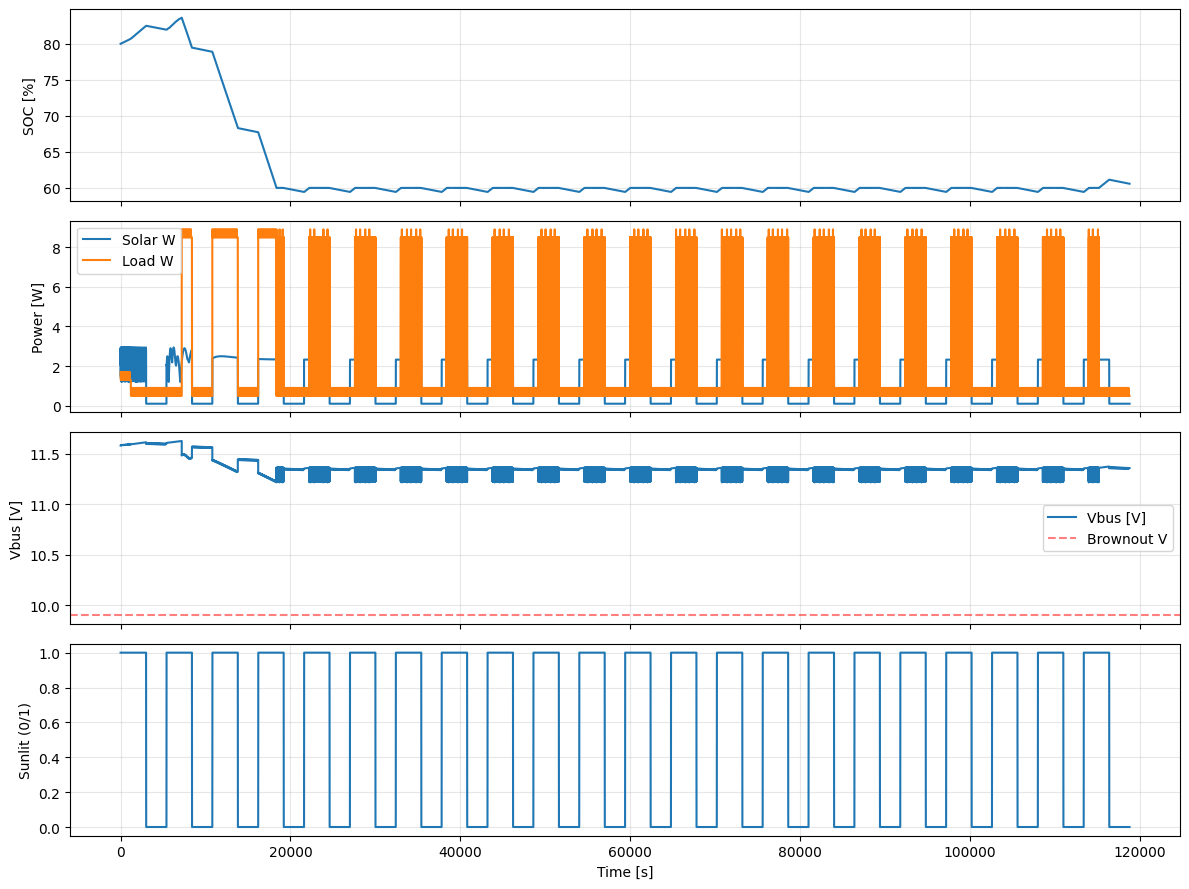

In [23]:
# Plot results
import matplotlib.pyplot as plt

fig, ax = plt.subplots(4, 1, figsize=(12, 9), sharex=True)
ax[0].plot(soc_log*100.0)
ax[0].set_ylabel('SOC [%]')
ax[0].grid(True, alpha=0.3)

ax[1].plot(solar_w_log, label='Solar W')
ax[1].plot(load_w_log, label='Load W')
ax[1].legend(); ax[1].set_ylabel('Power [W]')
ax[1].grid(True, alpha=0.3)

ax[2].plot(v_bus_log, label='Vbus [V]')
ax[2].axhline(batt.v_brownout_v, color='r', linestyle='--', alpha=0.5, label='Brownout V')
ax[2].legend(); ax[2].set_ylabel('Vbus [V]')
ax[2].grid(True, alpha=0.3)

ax[3].plot([1 if is_sunlit(t, orbit) else 0 for t in range(len(soc_log))])
ax[3].set_ylabel('Sunlit (0/1)'); ax[3].set_xlabel('Time [s]')
ax[3].grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [24]:
# Metrics summary
# Power Positive: True if SoC never dips below the configured reserve (e.g., 5%)
power_positive = bool(np.all(soc_log >= batt.soc_min))

# Average battery SoC over the full simulation window (fraction)
avg_soc = float(np.mean(soc_log))

print("Power Positive:", power_positive)
print(f"Average battery SoC: {avg_soc*100:.2f}%")

# Additional metrics
min_vbus = float(np.min(v_bus_log))
max_vbus = float(np.max(v_bus_log))
num_brownouts = int(np.sum(v_bus_log < batt.v_brownout_v))
print(f"Vbus min/max: {min_vbus:.2f}V / {max_vbus:.2f}V")
print(f"Seconds below brownout: {num_brownouts}")


Power Positive: True
Average battery SoC: 62.40%
Vbus min/max: 11.22V / 11.63V
Seconds below brownout: 0
